# Green_Team_Inference_Framework
## Utilizing ICEES, Ros, Gamma, and other services, to find meaningful connections.
<br>

![ros_asthma_graph_large](ros_asthma_graph_large.png)

## Figure 1. A graph, generated by Ros, utilizing Gamma, ICEES, and other Translator services. Using information in the drug:disease ICEES-derived edges, a list of FDA-approved drugs will be ranked for efficacy. Later, ROBOKOP-derived edges will be used in finding the gene nodes impacted by chemical exposure.

In [10]:
import json
import pandas
import networkx
from pandas.io.json import json_normalize
from collections import defaultdict
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#The above allows for the import of local modules (ros.client) in this notebook
from ros.client import Client

In [11]:
workflow = '../../ros-t10r/translator/ros/workflows/green-cqs.ros'
libpath = [ '../../ros-t10r/translator/ros/workflows' ]
args = {
    "disease_name" : "asthma",
    "drug_name" : "Prednisone"
}
""" general. """
ros = Client (url="http://localhost:5002")
response = ros.run (workflow=workflow,
                    args = args,
                    library_path = libpath)

In [12]:
data = json.dumps(response.result) #this is a string
data_json = json.loads(data) #this is a list
icees_result_graph = data_json[0][0]['result_list'][0]['result_graph']
icees_node_list = icees_result_graph['node_list']
icees_edge_list = icees_result_graph['edge_list']

In [13]:
icees_edge_list

[{'type': 'icees_associated_with',
  'source_id': 'MESH:D011241',
  'target_id': 'MONDO:0004979',
  'edge_attributes': {'chi_squared': 109.962169908,
   'feature_matrix': [[{'frequency': 16201,
      'column_percentage': 0.9049826835,
      'total_percentage': 0.7538153732,
      'row_percentage': 0.8420915848},
     {'frequency': 3038,
      'column_percentage': 0.8462395543,
      'total_percentage': 0.1413549228,
      'row_percentage': 0.1579084152}],
    [{'frequency': 1701,
      'column_percentage': 0.0950173165,
      'total_percentage': 0.0791457286,
      'row_percentage': 0.7549933422},
     {'frequency': 552,
      'column_percentage': 0.1537604457,
      'total_percentage': 0.0256839754,
      'row_percentage': 0.2450066578}]],
   'feature_b': {'feature_qualifiers': [{'operator': '=', 'value': 0},
     {'operator': '=', 'value': 1}],
    'feature_name': 'Prednisone'},
   'columns': [{'frequency': 17902, 'percentage': 0.8329611018},
    {'frequency': 3590, 'percentage': 0.1

In [14]:
source_id_list = []
for x in icees_node_list:
    for key, value in x.items():
        if key == 'name':
            source_id_list.append(x['id'])

In [20]:
all_icees_edges_dict = defaultdict(dict)

for x in icees_edge_list:
    icees_edge_dict = defaultdict(dict)
    for key, value in x.items():
        if key == 'source_id' and value in source_id_list:
            icees_edge_dict = defaultdict(dict)
            icees_edge_data = x['edge_attributes']
            drug_name = icees_edge_data['feature_b']['feature_name']
            source_id = value             
            if all_icees_edges_dict[drug_name]:
                all_icees_edges_dict[drug_name]['source_id'].append(source_id)
            else:
                number_patients_in_cohort = icees_edge_data['total']
                patients_with_ED_under_2_total_cohort = icees_edge_data['columns'][0]['frequency']
                patients_with_ED_over_2_total_cohort = icees_edge_data['columns'][1]['frequency']
                percentage_patients_with_ED_under_2_total_cohort = 100*patients_with_ED_under_2_total_cohort/number_patients_in_cohort
                number_patients_this_drug_EDVisits_under_2 = icees_edge_data['feature_matrix'][1][0]['frequency']
                tx_no_event = number_patients_this_drug_EDVisits_under_2
                
                number_patients_this_drug_EDVisits_over_2 = icees_edge_data['feature_matrix'][1][1]['frequency']
                tx_event = number_patients_this_drug_EDVisits_over_2
                
                number_patients_admin_this_drug = icees_edge_data['rows'][1]['frequency']
                number_patients_other_drugs_EDVisits_less_than_2 = icees_edge_data['feature_matrix'][0][0]['frequency']
                no_tx_no_event = number_patients_other_drugs_EDVisits_less_than_2
                
                number_patients_other_drugs_EDVisits_over_2 = icees_edge_data['feature_matrix'][0][1]['frequency']
                no_tx_event = number_patients_other_drugs_EDVisits_over_2
                
                number_patients_admin_other_drugs = icees_edge_data['rows'][0]['frequency']
                
                percentage_of_cohort_taking_this_drug = 100*number_patients_admin_this_drug / number_patients_in_cohort
                icees_edge_dict['% patients admin. this drug'] = percentage_of_cohort_taking_this_drug
                
                RR = (tx_event/(tx_event+tx_no_event))/(no_tx_event/(no_tx_event+no_tx_no_event))
                icees_edge_dict['Risk Ratio'] = RR
                
                OR = (tx_event*no_tx_no_event)/(tx_no_event*no_tx_event)
                icees_edge_dict['Odds Ratio'] = OR
                all_icees_edges_dict[drug_name]=dict(icees_edge_dict)
                all_icees_edges_dict[drug_name]['source_id'] = []
                all_icees_edges_dict[drug_name]['source_id'].append(source_id) 

<br><br>
## COHORT:45 --> size: 21492, features: AvgDailyPM2.5Exposure > 2

In [21]:
all_icees_edges_dict_df = pandas.DataFrame(all_icees_edges_dict)
efficacy_sorted_icees_edges_dict_df= all_icees_edges_dict_df.T.sort_values('Risk Ratio', ascending=False).T
efficacy_sorted_icees_edges_dict_df.round(2)

,Salmeterol,Diphenhydramine,Prednisone,Albuterol,Budesonide,Cetirizine,Mometasone
% patients admin. this drug,0.204727,13.3864,10.483,28.8759,4.59241,5.25312,1.56803
Odds Ratio,3.46464,1.8147,1.73057,1.11943,0.73356,0.717686,0.4652
Risk Ratio,2.45638,1.61194,1.55157,1.09813,0.768114,0.753694,0.511222
source_id,[PUBCHEM:5152],"[MESH:D004155, PUBCHEM:3100]","[MESH:D011241, PUBCHEM:5865]","[MESH:D000420, PUBCHEM:2083]","[MESH:D019819, PUBCHEM:5281004]","[MESH:D017332, PUBCHEM:2678]",[PUBCHEM:441335]


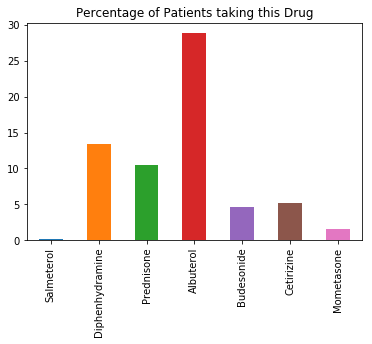

In [22]:
plot1 = efficacy_sorted_icees_edges_dict_df.iloc[1].plot(kind='bar',title = 'Percentage of Patients taking this Drug')

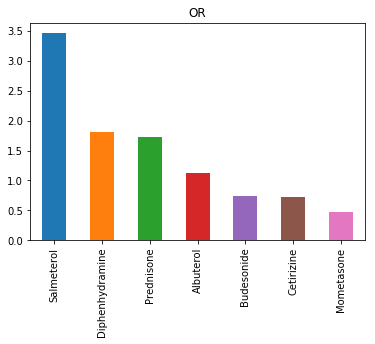

In [21]:
plot0 = efficacy_sorted_icees_edges_dict_df.iloc[0].plot(kind='bar',title = 'OR')

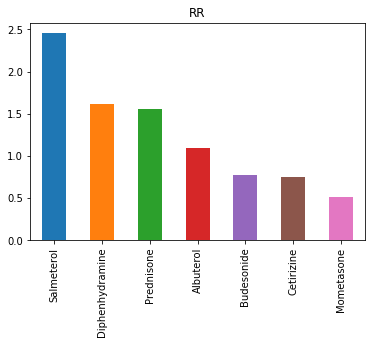

In [23]:
plot3 = efficacy_sorted_icees_edges_dict_df.iloc[2].plot(kind='bar',title = 'RR')

In [26]:
RR_sorted_icees_edges_dict_df= all_icees_edges_dict_df.T.sort_values('RR', ascending=False).T
thing = list(RR_sorted_icees_edges_dict_df)
thing

['Salmeterol',
 'Diphenhydramine',
 'Prednisone',
 'Albuterol',
 'Budesonide',
 'Cetirizine',
 'Mometasone']

#### Until we have the graph from Ros providing all edge details, we will manually supply some, as below...

In [27]:
all_edges_dict = {}
edge_dict = {}
file_list = ['cetirizine-edges.txt', 'prednisone-edges.txt']
for x in file_list:
    with open(x, 'r') as text:  
        for line in text: 
            if '<id>' in line:
                edge_key = line
                edge_dict[edge_key] =  {}
            if 'source_id' in line:
                stuff = line.split(':',1)
                key = stuff[0]
                value = stuff[1]
                edge_dict[edge_key][key] = value
            if 'target_id'in line:
                stuff = line.split(':',1)
                key = stuff[0]
                value = stuff[1]
                edge_dict[edge_key][key] = value
            if 'pred' in line:
                stuff = line.split(':',1)
                key = stuff[0]
                value = stuff[1]
                edge_dict[edge_key][key] = value
            if 'scoring' in line:
                stuff = line.split(':',1)
                key = stuff[0]
                value = stuff[1]
                edge_dict[edge_key][key] = value
for key, value in edge_dict.items():
    if value['source_id']:
        if 'CHEBI:8382' in value['source_id']:       
            edge_dict[key]['name'] = 'prednisone'
        elif 'CHEBI:3561' in value['source_id']:
            edge_dict[key]['name'] = 'cetirizine'                    
#print(edge_dict)

In [28]:
import os

prednisone_targets = []
cetirizine_target_dict = defaultdict(dict)
for key, value in edge_dict.items(): 
    if 'pred' in value['name']:
        gene_info = [{'source_id':value['source_id']},{'target_id':value['target_id']}, {'scoring':value['scoring']}]      
        prednisone_targets.append(gene_info)
prednisone_target_id_list = []
for x in prednisone_targets:
    temp = x[1]['target_id'].rstrip(os.linesep)
    if temp not in prednisone_target_id_list:
        prednisone_target_id_list.append(temp) 
prednisone_target_id_list

['HGNC:7978', 'HGNC:5209', 'MONDO:0004979', 'HGNC:4632']

In [29]:
PM_25_gene_list = ['CAT', 'IL4', 'GSTP1', 'IL2', 'CXCL1', 'MUCSAC', 'IL5', 'NFKBIA', 'IFNG', 'IL13', 'PTEN', 'TLR4', 'JUN', 'ACE', 'GSTM1', 'CCL3', 'CCR2', 'CCL5', 'VEGPA']

In [30]:
genes_affected_by_PM25 = defaultdict(dict)
genes_affected_by_PM25['GSTM1']['target_id'] = 'HGNC:4632'
genes_affected_by_PM25['IL5']['target_id'] = ['HGNC:6016', 'NCBIGENE:3567']
genes_affected_by_PM25['TBX21']['target_id'] = 'HGNC:11599'
genes_affected_by_PM25

defaultdict(dict,
            {'GSTM1': {'target_id': 'HGNC:4632'},
             'IL5': {'target_id': ['HGNC:6016', 'NCBIGENE:3567']},
             'TBX21': {'target_id': 'HGNC:11599'}})

In [31]:
genes_affected_by_PM25_and_drug = []
for key, value in genes_affected_by_PM25.items():
    if value['target_id'] in prednisone_target_id_list:
        genes_affected_by_PM25_and_drug.append(value['target_id'])
genes_affected_by_PM25_and_drug

['HGNC:4632']

In [32]:
efficacy_sorted_icees_edges_dict_df.at['Genes affected by Drug (target IDs)','Prednisone'] = prednisone_target_id_list

In [33]:
efficacy_sorted_icees_edges_dict_df.at['Genes affected by Drug and PM2.5 (target IDs)', 'Prednisone'] = genes_affected_by_PM25_and_drug

In [34]:
efficacy_sorted_icees_edges_dict_df

,Salmeterol,Diphenhydramine,Prednisone,Albuterol,Budesonide,Cetirizine,Mometasone
OR,3.46464,1.8147,1.73057,1.11943,0.73356,0.717686,0.4652
Percentage of Cohort administered this Drug,0.204727,13.3864,10.483,28.8759,4.59241,5.25312,1.56803
RR,2.45638,1.61194,1.55157,1.09813,0.768114,0.753694,0.511222
source_id,[PUBCHEM:5152],"[MESH:D004155, PUBCHEM:3100]","[MESH:D011241, PUBCHEM:5865]","[MESH:D000420, PUBCHEM:2083]","[MESH:D019819, PUBCHEM:5281004]","[MESH:D017332, PUBCHEM:2678]",[PUBCHEM:441335]
Genes affected by Drug (target IDs),NaN,NaN,"[HGNC:7978, HGNC:5209, MONDO:0004979, HGNC:4632]",NaN,NaN,NaN,NaN
Genes affected by Drug and PM2.5 (target IDs),NaN,NaN,[HGNC:4632],NaN,NaN,NaN,NaN


# CQ4 OUTPUT: 

<br> 
# CQ5 Goal:  Ranked lists of the protein (gene) targets and biological pathways of FDA-approved medications that are effective in patients with asthma and high levels of exposure to airborne pollutants

![ros_asthma_graph_small](ros_asthma_graph_small.png)

## Figure 2.  Detail of the network graph from Figure 1, many nodes and edges removed. The remaining nodes and connections represent the drug-gene-disease pathways examined for CQ5.

<br> 
# Further Knowledge Goal: Vary AvgDailyPM2.5Exposure, examine effectiveness of drugs over that variation, look for influence of genes in that variation

# Next Implementation Goal: Convert this algorithm/code to a CLI and/or GUI tool